<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter

import seaborn as sns
import os
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Reading original data

In [3]:
PATH_TO_DATA = ('../../data/alice_competition')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

site_columns, time_columns = [[c for c in train_df.columns if s in c] for s in ['site', 'time']]

Separate target feature 

In [4]:
y = train_df['target']

Parse datetimes, sort by time1

In [5]:
train_df[time_columns] = train_df[time_columns].apply(pd.to_datetime)
test_df[time_columns] = test_df[time_columns].apply(pd.to_datetime)
train_df['time_last'] = train_df[time_columns].apply(max, axis=1)
test_df['time_last'] = test_df[time_columns].apply(max, axis=1)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

Load sites dictionary, transform sites

In [6]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
train_df[site_columns] = train_df[site_columns].fillna(0).astype('int')
test_df[site_columns] = test_df[site_columns].fillna(0).astype('int')

# Load websites dictionary
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), "rb") as input_file:
    sites_dict = pickle.load(input_file)

site_by_idx = {v: k for k, v in sites_dict.items()}

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(sites_dict.keys()), index=list(sites_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


## Explore dataset

In [7]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,target,time_last
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,0,NaT,0,NaT,0,NaT,0,NaT,0,2013-01-12 08:05:57
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,0,NaT,0,NaT,0,NaT,0,NaT,0,2013-01-12 09:07:09
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,2013-01-12 08:50:22


123776 visits of site idx=21 address  www.google.fr
122730 visits of site idx=0 address  None
87619 visits of site idx=23 address  www.google.com
77055 visits of site idx=782 address  annotathon.org
58258 visits of site idx=22 address  apis.google.com
54094 visits of site idx=29 address  www.facebook.com
46405 visits of site idx=167 address  www.bing.com
43841 visits of site idx=780 address  blast.ncbi.nlm.nih.gov
38194 visits of site idx=778 address  www.ncbi.nlm.nih.gov
36085 visits of site idx=52 address  clients1.google.com


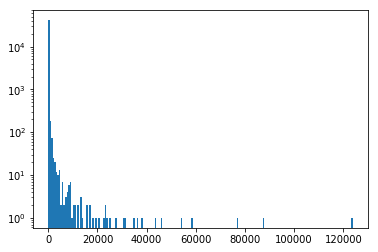

In [8]:
# unique sites
sites, sites_counts = np.unique(train_df[site_columns].values, return_counts=True)
f = plt.hist(sites_counts[1:], log=True, bins=200)   # drop nan

top_n = 10
for idx, count in sorted(zip(sites, sites_counts), key=lambda x: -x[1])[:top_n]:
    print("{} visits of site idx={} address  {}".format(count, idx, site_by_idx.get(idx)))

1382 visits for Alice of site idx=77 address  i1.ytimg.com
1354 visits for Alice of site idx=80 address  s.youtube.com
1307 visits for Alice of site idx=76 address  www.youtube.com
897 visits for Alice of site idx=29 address  www.facebook.com
857 visits for Alice of site idx=21 address  www.google.fr
609 visits for Alice of site idx=81 address  r4---sn-gxo5uxg-jqbe.googlevideo.com
522 visits for Alice of site idx=22 address  apis.google.com
522 visits for Alice of site idx=879 address  r1---sn-gxo5uxg-jqbe.googlevideo.com
451 visits for Alice of site idx=75 address  s.ytimg.com
447 visits for Alice of site idx=82 address  r2---sn-gxo5uxg-jqbe.googlevideo.com


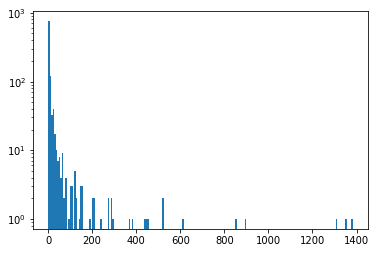

In [9]:
# unique sites for Alice
# unique sites
sites, sites_counts = np.unique(train_df.loc[y == 1, site_columns].values, return_counts=True)
f = plt.hist(sites_counts[1:], log=True, bins=200)   # drop nan

top_n = 10
for idx, count in sorted(zip(sites, sites_counts), key=lambda x: -x[1])[:top_n]:
    print("{} visits for Alice of site idx={} address  {}".format(count, idx, site_by_idx.get(idx)))

## Add features based on the session start time / end time / duration: 
hour, whether it's morning, day or night and so on.

In [11]:
# day of week, is weekend; train_df.groupby('time1_weekday').size()
for df in [train_df, test_df]:
    df['time1_weekday'] = df['time1'].apply(lambda dt: dt.date().weekday())
    df['time1_is_weekend'] = df['time1_weekday'].isin((5,6)).astype(int)
    df['time1_weekday_cos'] = np.cos(df['time1_weekday'] * 2 * np.pi / 7)
    df['time1_weekday_sin'] = np.sin(df['time1_weekday'] * 2 * np.pi / 7)


    # hour of day, part of day?
    df['time1_hour'] = df['time1'].apply(lambda dt: dt.hour)
    df['time_last_hour'] = df['time_last'].apply(lambda dt: dt.hour)
    df['time1_hour_cos'] = np.cos(df['time1_hour'] * 2 * np.pi / 24)
    df['time1_hour_sin'] = np.sin(df['time1_hour'] * 2 * np.pi / 24)
    df['time1_hour_popular'] = df['time1_hour'].isin((12, 13, 16, 17, 18)).astype(int)

    # duration of session
    df['session_duration'] = (df['time_last'] - df['time1']).apply(lambda x: x.total_seconds())
    
    df['time1_working_hour'] = ((9 <= df['time1_hour']) & (df['time1_hour'] <= 18)).astype(int)
    df['time_last_working_hour'] = ((9 <= df['time_last_hour']) & (df['time_last_hour'] <= 18)).astype(int)

In [12]:
print(Counter([tuple(row) for row in train_df[['time1_working_hour', 'time_last_working_hour']].values]))
train_df[['time1_working_hour', 'time_last_working_hour', 'target']].corr()

Counter({(1, 1): 220472, (0, 0): 31786, (0, 1): 1175, (1, 0): 128})


,time1_working_hour,time_last_working_hour,target
time1_working_hour,1.000000,0.977137,0.036958
time_last_working_hour,0.977137,1.000000,0.036281
target,0.036958,0.036281,1.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bc0b0ab38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3bc17e5dd8>], dtype=object)

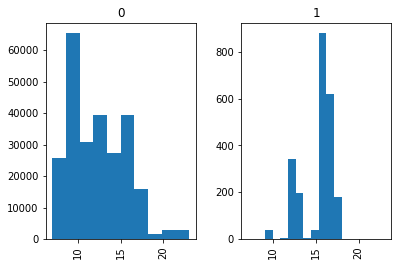

In [13]:
# hour of day by target
train_df.hist('time1_hour', by='target', sharex=True)

### top-n hours and days of week

In [14]:
hours_cnt = Counter(train_df[y == 1]['time1_hour'])       
for df in [train_df, test_df]:
    for top_n in np.linspace(1, 24, 24):
        top_hours = [idx for idx, _ in hours_cnt.most_common(int(top_n))]

        df['alice_hour_top_{}'.format(top_n)] = df['time1_hour'].isin(top_hours).astype(int)
        df['alice_hour_antitop_{}'.format(top_n)] = (~df['time1_hour'].isin(top_hours)).astype(int)


weekdays_cnt = Counter(train_df[y == 1]['time1_weekday'])       
for df in [train_df, test_df]:
    for top_n in np.linspace(1, 7, 7):
        top_weekdays = [idx for idx, _ in weekdays_cnt.most_common(int(top_n))]

        df['alice_weekday_top_{}'.format(top_n)] = df['time1_weekday'].isin(top_weekdays).astype(int)
        df['alice_weekday_antitop_{}'.format(top_n)] = (~df['time1_weekday'].isin(top_weekdays)).astype(int)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bc1983cf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3bc23ebf60>], dtype=object)

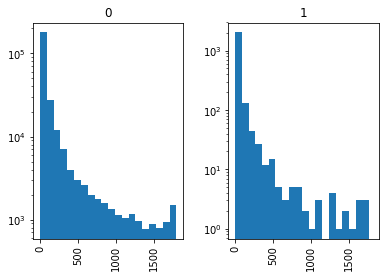

In [15]:
# duration by target
train_df.hist('session_duration', by='target', sharex=True, log=True, bins=20)

## Add "sites in Alice's top-N" features

In [16]:
sites, alice_counts = np.unique(train_df[y == 1][site_columns], return_counts=True)

sites_cnt = Counter()
for site, alice_count in zip(sites, alice_counts):
    if site != 0:
        sites_cnt[site] = alice_count

In [17]:
for df in [train_df, test_df]:
    for top_n in np.logspace(0, 12, 13, base=2):
        top_sites = [idx for idx, _ in sites_cnt.most_common(int(top_n))]

        isin_alice = df[site_columns].isin(top_sites)
        df['alice_any_top_{}'.format(top_n)] = isin_alice.any(axis=1).astype(int)
        not_nan = (df[site_columns] > 0).sum(axis=1)
        df['alice_part_top_{}'.format(top_n)] = isin_alice.sum(axis=1) / not_nan

## Add "sites Alice never visited" features

In [18]:
len(sites_cnt), len(np.unique(train_df[site_columns]))

(1053, 41602)

In [19]:
never_visited = set(np.unique(train_df[site_columns])) - set(sites_cnt) - {0}

In [20]:
train_df['alice_never_visited'] = train_df[site_columns].isin(never_visited).all(axis=1).astype(int)
test_df['alice_never_visited'] = test_df[site_columns].isin(never_visited).all(axis=1).astype(int)

Counter([tuple(row) for row in train_df[['alice_never_visited', 'target']].values])

Counter({(0, 0): 212483, (0, 1): 2297, (1, 0): 38781})

In [21]:
for df in [train_df, test_df]:
    never_visited = df[site_columns].isin(never_visited).sum(axis=1)
    not_nan = (df[site_columns] > 0).sum(axis=1)
    df['alice_never_visited_part'] = never_visited / not_nan

In [22]:
train_df[['alice_never_visited', 'alice_never_visited_part', 'target']].corr()

,alice_never_visited,alice_never_visited_part,target
alice_never_visited,1.000000,0.600581,-0.040628
alice_never_visited_part,0.600581,1.000000,-0.134959
target,-0.040628,-0.134959,1.000000


## Add OHE for each 'categorical' feature

In [23]:
pd.concat([train_df.drop('target', axis=1), test_df]).shape, test_df.shape, train_df.shape

((336358, 123), (82797, 123), (253561, 124))

In [24]:
%%time
site_address_columns = [c + '_address' for c in site_columns]
not_ohe_columns = site_columns + time_columns + site_address_columns
not_ohe_columns += ['time_last', 'session_duration', 'sites_addresses_merged', 'sites_idxs_merged']
not_ohe_columns += ['time1_hour_cos', 'time1_hour_sin', 'time1_weekday_cos', 'time1_weekday_sin']

not_ohe_columns = list(set(not_ohe_columns) & set(train_df.columns))
df_for_ohe_fit = pd.concat([train_df.drop('target', axis=1), test_df]).drop(not_ohe_columns, axis=1)

enc = OneHotEncoder()
df_ohe_transformed = enc.fit_transform(df_for_ohe_fit)

CPU times: user 10.4 s, sys: 2.52 s, total: 12.9 s
Wall time: 12.9 s


In [25]:
train_df_ohe = df_ohe_transformed[:train_df.shape[0]]
test_df_ohe = df_ohe_transformed[train_df.shape[0]:]

In [26]:
train_df_ohe.shape, test_df_ohe.shape

((253561, 230), (82797, 230))

## Save results

In [27]:
#train_df.to_csv(os.path.join(PATH_TO_DATA, 'train_sessions_time_top_n.csv'))
#test_df.to_csv(os.path.join(PATH_TO_DATA, 'test_sessions_time_top_n.csv'))
train_df[['target'] + list(set(train_df.columns) - {'target'})].corr().sort_values(by='target', ascending=False)

,target,alice_part_top_2.0,time1_working_hour,alice_weekday_antitop_4.0,time1_is_weekend,alice_any_top_4.0,alice_hour_antitop_18.0,alice_any_top_16.0,alice_weekday_top_7.0,alice_hour_top_23.0,...,site3,alice_any_top_1024.0,time_last_hour,alice_never_visited_part,alice_hour_antitop_19.0,alice_part_top_4.0,alice_hour_top_3.0,alice_hour_antitop_6.0,alice_any_top_8.0,alice_hour_top_4.0
target,1.000000,0.106773,0.036958,-0.057194,-0.024221,0.091422,-0.057087,0.045235,NaN,0.057087,...,-0.003669,0.046110,0.094383,-0.134959,-0.057087,0.124566,0.146886,-0.117537,0.047418,0.128092
alice_hour_top_2.0,0.152682,0.043616,0.145767,-0.026155,-0.012897,0.036087,-0.225158,0.054676,NaN,0.225158,...,-0.014878,0.060475,0.490049,-0.063523,-0.225158,0.049238,0.770612,-0.478775,0.044477,0.601511
alice_hour_top_3.0,0.146886,0.066097,0.189158,-0.023756,-0.028206,0.058467,-0.292181,0.065066,NaN,0.292181,...,0.002969,0.076638,0.393524,-0.090303,-0.292181,0.074554,1.000000,-0.621292,0.056504,0.780564
time1_hour_popular,0.139179,0.073313,0.251557,-0.042869,-0.029628,0.053262,-0.388566,0.065623,NaN,0.388566,...,-0.000137,0.085564,0.444962,-0.094208,-0.388566,0.076898,0.751947,-0.826245,0.059197,0.963338
alice_hour_top_5.0,0.139179,0.073313,0.251557,-0.042869,-0.029628,0.053262,-0.388566,0.065623,NaN,0.388566,...,-0.000137,0.085564,0.444962,-0.094208,-0.388566,0.076898,0.751947,-0.826245,0.059197,0.963338
alice_part_top_2048.0,0.134959,0.267773,0.027246,0.018247,-0.008025,0.311875,-0.056091,0.455163,NaN,0.056091,...,-0.227456,0.681618,0.033799,-1.000000,-0.056091,0.337841,0.090303,-0.093420,0.424383,0.093053
alice_part_top_4096.0,0.134959,0.267773,0.027246,0.018247,-0.008025,0.311875,-0.056091,0.455163,NaN,0.056091,...,-0.227456,0.681618,0.033799,-1.000000,-0.056091,0.337841,0.090303,-0.093420,0.424383,0.093053
alice_part_top_1024.0,0.134627,0.267796,0.027227,0.018271,-0.008013,0.311859,-0.056064,0.455157,NaN,0.056064,...,-0.227517,0.681624,0.033757,-0.999990,-0.056064,0.337852,0.090250,-0.093376,0.424370,0.092997
alice_part_top_256.0,0.134187,0.325978,0.034004,0.018706,-0.010167,0.330298,-0.057384,0.470870,NaN,0.057384,...,-0.212527,0.608604,0.034274,-0.906383,-0.057384,0.390611,0.085618,-0.086510,0.454113,0.085533
alice_part_top_512.0,0.133790,0.287162,0.034762,0.016702,-0.011750,0.317262,-0.059382,0.467945,NaN,0.059382,...,-0.222953,0.651149,0.029891,-0.962969,-0.059382,0.355330,0.092020,-0.091647,0.441726,0.092322


## Build Tf-Idf features based on sites (idxs and addresses)
[TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

Одна сессия -- это документ. один сайт (его индекс или адрес) -- это терм

In [46]:
%%time
# join site addresses to dataframes
for df in [train_df, test_df]:
    for site_col in site_columns:
        addresses = sites_dict.loc[df[site_col]]
        addresses.index = df.index
        df[site_col + '_address'] = addresses
site_address_columns = [c + '_address' for c in site_columns]

CPU times: user 2.17 s, sys: 36 ms, total: 2.21 s
Wall time: 2.21 s


In [47]:
%%time
# join strings
train_df['sites_idxs_merged'] = train_df[site_columns].apply(
    lambda x: " ".join([str(int(v)) for v in x if not np.isnan(v)]), 
    axis=1
)
train_df['sites_addresses_merged'] = train_df[site_address_columns].apply(
    lambda x: " ".join([v for v in x if isinstance(v, str)]), 
    axis=1
)

test_df['sites_idxs_merged'] = test_df[site_columns].apply(
    lambda x: " ".join([str(int(v)) for v in x if not np.isnan(v)]), 
    axis=1
)
test_df['sites_addresses_merged'] = test_df[site_address_columns].apply(
    lambda x: " ".join([v for v in x if isinstance(v, str)]), 
    axis=1
)

CPU times: user 33.7 s, sys: 112 ms, total: 33.8 s
Wall time: 33.8 s


In [21]:
train_df[site_columns].values.min(), train_df[site_columns].values.max()

(0, 41601)

In [48]:
%%time
# tf-idf on site idxs
tf_idf_idxs = TfidfVectorizer(ngram_range=(1, 5), max_features=42000)
tf_idf_idxs.fit(pd.concat([train_df['sites_idxs_merged'], test_df['sites_idxs_merged']]))    # not very honest

train_df_tf_idf_on_site_idxs = tf_idf_idxs.transform(train_df['sites_idxs_merged'])
test_df_tf_idf_on_site_idxs = tf_idf_idxs.transform(test_df['sites_idxs_merged'])

CPU times: user 44.4 s, sys: 388 ms, total: 44.8 s
Wall time: 44.8 s


In [49]:
train_df['sites_addresses_merged'] = train_df['sites_addresses_merged'].apply(lambda s: s.replace('.', ' '))
test_df['sites_addresses_merged'] = test_df['sites_addresses_merged'].apply(lambda s: s.replace('.', ' '))

In [50]:
%%time
# tf-idf on site addresses
tf_idf_addr = TfidfVectorizer(ngram_range=(5, 10), max_features=50000)
tf_idf_addr.fit(pd.concat([train_df['sites_addresses_merged'], test_df['sites_addresses_merged']]))    # not very honest

train_df_tf_idf_on_site_addr = tf_idf_addr.transform(train_df['sites_addresses_merged'])
test_df_tf_idf_on_site_addr = tf_idf_addr.transform(test_df['sites_addresses_merged'])

CPU times: user 2min 52s, sys: 3.7 s, total: 2min 55s
Wall time: 2min 55s


## Calculate sparse matrix for "site N was visited"

In [28]:
full_sites = pd.concat([train_df.drop('target', axis=1), test_df])[site_columns]
idx_split = train_df.shape[0]

sites_flatten = full_sites.values.flatten()
sites_sparse = csr_matrix(([1] * sites_flatten.shape[0], sites_flatten,
                             range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

train_df_sparse = sites_sparse[:idx_split]
test_df_sparse = sites_sparse[idx_split:]

## Scale and combine features
(you'll need `scipy.sparse.hstack`)

In [40]:
# filter only numeric columns for prediction
X_columns = [c for c, t in zip(train_df.columns, train_df.dtypes) if t in [np.int64, np.float64] and c != 'target']
print("dropping: ", set(train_df.columns) - set(X_columns))
print("\nlearning on:", X_columns)

X_learn, y_learn = train_df[X_columns], train_df['target']
X_test = test_df[X_columns]

dropping:  {'time5', 'time2', 'time_last', 'time3', 'time9', 'time8', 'time1', 'target', 'time6', 'time10', 'time7', 'time4'}

learning on: ['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10', 'time1_weekday', 'time1_is_weekend', 'time1_weekday_cos', 'time1_weekday_sin', 'time1_hour', 'time_last_hour', 'time1_hour_cos', 'time1_hour_sin', 'time1_hour_popular', 'session_duration', 'time1_working_hour', 'time_last_working_hour', 'alice_hour_top_1.0', 'alice_hour_antitop_1.0', 'alice_hour_top_2.0', 'alice_hour_antitop_2.0', 'alice_hour_top_3.0', 'alice_hour_antitop_3.0', 'alice_hour_top_4.0', 'alice_hour_antitop_4.0', 'alice_hour_top_5.0', 'alice_hour_antitop_5.0', 'alice_hour_top_6.0', 'alice_hour_antitop_6.0', 'alice_hour_top_7.0', 'alice_hour_antitop_7.0', 'alice_hour_top_8.0', 'alice_hour_antitop_8.0', 'alice_hour_top_9.0', 'alice_hour_antitop_9.0', 'alice_hour_top_10.0', 'alice_hour_antitop_10.0', 'alice_hour_top_11.0', 'alice_hour_antitop_11.0',

In [41]:
# scale datasets
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(pd.concat([X_learn, X_test]))

X_learn = scaler.transform(X_learn)
X_test = scaler.transform(X_test)

In [42]:
from scipy.sparse import csr_matrix

# combine with simple "site visited" sparse table
X_learn = csr_matrix(hstack([X_learn, train_df_sparse]))
X_test = csr_matrix(hstack([X_test, test_df_sparse]))

In [32]:
"""# combine with ohe encoding
X_learn = csr_matrix(hstack([X_learn, train_df_ohe]))
X_test = csr_matrix(hstack([X_test, test_df_ohe]))"""

In [51]:
# combine with tf-idf
X_learn = csr_matrix(hstack([X_learn, train_df_tf_idf_on_site_idxs, train_df_tf_idf_on_site_addr]))
X_test = csr_matrix(hstack([X_test, test_df_tf_idf_on_site_idxs, test_df_tf_idf_on_site_addr]))

In [52]:
X_learn

<253561x140483 sparse matrix of type '<class 'numpy.float64'>'
	with 45757270 stored elements in Compressed Sparse Row format>

## Perform cross-validation with logistic regression.

In [44]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9, class_weight=None, penalty='l2'):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1, penalty=penalty, class_weight=class_weight)
    lr = lr.fit(X[:idx], y[:idx])
    
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:])[:, 1]
    
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [ ]:
"""for C in [0.001, 0.01, 0.1, 1, 10]:
    for class_weight in ['balanced', None]:
        for penalty in ['l1', 'l2']:
            score_90 = get_auc_lr_valid(X_learn, y_learn, C=C, ratio=0.9, class_weight=class_weight, penalty=penalty)
            print("C={}, class_weight={}, penalty={}, score={:.5f} on 90%"
                  .format(C, class_weight, penalty, score_90))"""

C=0.001, class_weight=balanced, penalty=l1, score=0.99448 on 90%
C=0.001, class_weight=balanced, penalty=l2, score=0.99425 on 90%
C=0.001, class_weight=None, penalty=l1, score=0.98958 on 90%
C=0.001, class_weight=None, penalty=l2, score=0.99446 on 90%
C=0.01, class_weight=balanced, penalty=l1, score=0.99380 on 90%
C=0.01, class_weight=balanced, penalty=l2, score=0.99353 on 90%
C=0.01, class_weight=None, penalty=l1, score=0.99595 on 90%
C=0.01, class_weight=None, penalty=l2, score=0.99546 on 90%
C=0.1, class_weight=balanced, penalty=l1, score=0.99277 on 90%
C=0.1, class_weight=balanced, penalty=l2, score=0.99299 on 90%
C=0.1, class_weight=None, penalty=l1, score=0.99533 on 90%
C=0.1, class_weight=None, penalty=l2, score=0.99546 on 90%


```
C=0.01, class_weight=balanced, penalty=l1, score=0.9780459424469469
C=0.01, class_weight=balanced, penalty=l2, score=0.9794882106575076
C=0.01, class_weight=None, penalty=l1, score=0.985848139452874
C=0.01, class_weight=None, penalty=l2, score=0.9833794967851639
C=0.1, class_weight=balanced, penalty=l1, score=0.9782728347559768
C=0.1, class_weight=balanced, penalty=l2, score=0.978629401378684
C=0.1, class_weight=None, penalty=l1, score=0.9837952395789555
C=0.1, class_weight=None, penalty=l2, score=0.9843661688622234
C=1, class_weight=balanced, penalty=l1, score=0.9772386103985817
C=1, class_weight=balanced, penalty=l2, score=0.9772925029829621
C=1, class_weight=None, penalty=l1, score=0.9820847161234536
C=1, class_weight=None, penalty=l2, score=0.9826053758532237
```

In [35]:
get_auc_lr_valid(X_learn, y_learn, ratio=0.9)

0.99484337033655545

In [39]:
X_learn.shape

(253561, 48713)

## Make prediction for the test set and form a submission file.

(253561, 48713)

In [36]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [53]:
lr = LogisticRegression(random_state=17, C=1).fit(X_learn, y_learn)

y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'submissions/submission_10_no_ohe_real_params.tsv')

0.907